<a href="https://colab.research.google.com/github/SamanZargarzadeh/Deep-Learning/blob/main/18_Saving_and_Loading_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Import

In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [2]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [3]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#2) Load Data

In this notebook we will using be CIFAR-10 dataset. The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [5]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

170498071/170498071 [==============================] - 96s 1us/step


In [6]:
print("train X shape: ", x_train.shape) 
print("train y shape: ", y_train.shape)  
print("test X shape: ", x_test.shape)  
print("test y shape: ", y_test.shape)  

train X shape:  (10000, 32, 32, 3)
train y shape:  (10000, 1)
test X shape:  (1000, 32, 32, 3)
test y shape:  (1000, 1)


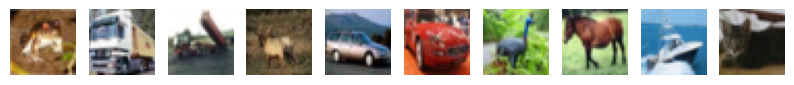

In [7]:
# Plot the first 10 CIFAR-10 images

fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

# 3) Introduce Two Useful Functions

In [8]:
# Introduce function that creates a new instance of a simple CNN

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [9]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

# 4) Create Simple CNN Classifier

In [10]:
# Create an instance of the model and show model summary

model = get_new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 7, 7, 8)           0         
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                12576     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 14,514
Trainable params: 14,514
Non-traina

In [11]:
# Test accuracy of the untrained model, around 10% (random)

get_test_accuracy(model, x_test, y_test)
# We've got 10 possible classifications. 
# You'd expect it to get around 10 percent accuracy as good as random guessing
# You might get a slightly different value due to a different initialization of this network but it should be around 10 percent.

accuracy: 0.106


# 5) Saving and Loading Model Weights

## 5-1) Saving the weights during training (using checkpoints)

### Train model with simple checkpoints

In [12]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_freq='epoch',
                             save_weights_only=True,
                             verbose=1)

This callback will save the model weights after every epoch. But because we're using the same file name to save the model, the saved weights will get overwritten every epoch.

In [13]:
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

model.fit(x_train, y_train, epochs=3, batch_size = 32, callbacks=[checkpoint])

Epoch 1/3
311/313 [============================>.] - ETA: 0s - loss: 1.9149 - accuracy: 0.2972
Epoch 1: saving model to model_checkpoints/checkpoint
313/313 [==============================] - 9s 25ms/step - loss: 1.9142 - accuracy: 0.2975
Epoch 2/3
312/313 [============================>.] - ETA: 0s - loss: 1.5683 - accuracy: 0.4340
Epoch 2: saving model to model_checkpoints/checkpoint
313/313 [==============================] - 8s 25ms/step - loss: 1.5681 - accuracy: 0.4341
Epoch 3/3
312/313 [============================>.] - ETA: 0s - loss: 1.4543 - accuracy: 0.4798
Epoch 3: saving model to model_checkpoints/checkpoint
313/313 [==============================] - 7s 22ms/step - loss: 1.4551 - accuracy: 0.4796


In [14]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoints

# the checkpoint.data (the biggest file), is where the actual weights are stored. The other things are metadata.

total 184K
-rw-r--r-- 1 root root   77 Jun  2 00:43 checkpoint
-rw-r--r-- 1 root root 174K Jun  2 00:43 checkpoint.data-00000-of-00001
-rw-r--r-- 1 root root 1.7K Jun  2 00:43 checkpoint.index


In [15]:
# Evaluate the performance of the trained model

get_test_accuracy(model, x_test, y_test)

accuracy: 0.485


Create new model, load weights:

In [16]:
# Create a new instance of the (initialised) model, accuracy around 10% again

model2 = get_new_model()
get_test_accuracy(model2, x_test, y_test)

accuracy: 0.105


In [17]:
# Load weights -- accuracy is the same as the trained model

model2.load_weights(checkpoint_path)
get_test_accuracy(model2, x_test, y_test)

accuracy: 0.485


Clear directory:

In [18]:
! rm -r model_checkpoints

### Train model with more customized checkpoints

In [19]:
# Create Tensorflow checkpoint object with epoch details

checkpoint_path = 'model_checkpoints/checkpoint_{epoch:02d}' 
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_freq='epoch',
                             save_weights_only=True,
                             verbose=1)

This callback will save the model weights after every epoch. And it's using different file names to save the weights after every epoch.

In [20]:
model = get_new_model()
model.fit(x_train, y_train, epochs=3, batch_size = 10, validation_data=(x_test,y_test) , callbacks=[checkpoint])

Epoch 1/3
 996/1000 [============================>.] - ETA: 0s - loss: 1.8800 - accuracy: 0.3107
Epoch 1: saving model to model_checkpoints/checkpoint_01
1000/1000 [==============================] - 10s 10ms/step - loss: 1.8804 - accuracy: 0.3102 - val_loss: 1.6730 - val_accuracy: 0.3900
Epoch 2/3
 996/1000 [============================>.] - ETA: 0s - loss: 1.5080 - accuracy: 0.4580
Epoch 2: saving model to model_checkpoints/checkpoint_02
1000/1000 [==============================] - 8s 8ms/step - loss: 1.5076 - accuracy: 0.4583 - val_loss: 1.4344 - val_accuracy: 0.4830
Epoch 3/3
 997/1000 [============================>.] - ETA: 0s - loss: 1.3678 - accuracy: 0.5091
Epoch 3: saving model to model_checkpoints/checkpoint_03
1000/1000 [==============================] - 9s 9ms/step - loss: 1.3683 - accuracy: 0.5087 - val_loss: 1.3911 - val_accuracy: 0.4910


In [21]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoints

total 544K
-rw-r--r-- 1 root root   83 Jun  2 00:46 checkpoint
-rw-r--r-- 1 root root 174K Jun  2 00:45 checkpoint_01.data-00000-of-00001
-rw-r--r-- 1 root root 1.7K Jun  2 00:45 checkpoint_01.index
-rw-r--r-- 1 root root 174K Jun  2 00:45 checkpoint_02.data-00000-of-00001
-rw-r--r-- 1 root root 1.7K Jun  2 00:45 checkpoint_02.index
-rw-r--r-- 1 root root 174K Jun  2 00:46 checkpoint_03.data-00000-of-00001
-rw-r--r-- 1 root root 1.7K Jun  2 00:46 checkpoint_03.index


### Train model with more customized checkpoints with model saving criteria

In [22]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [23]:
# Create a new instance of untrained model

model = get_new_model()

In [24]:
# Create Tensorflow checkpoint object which monitors the validation accuracy

checkpoint_best_path = 'model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                             save_freq='epoch',
                             save_weights_only=True,
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1)

In [25]:
# Fit the model and save only the weights with the highest validation accuracy

history = model.fit(x_train, y_train, epochs=50, batch_size = 10, validation_data=(x_test,y_test) , callbacks=[checkpoint_best], verbose=0)


Epoch 1: val_accuracy improved from -inf to 0.08000, saving model to model_checkpoints_best/checkpoint

Epoch 2: val_accuracy did not improve from 0.08000

Epoch 3: val_accuracy did not improve from 0.08000

Epoch 4: val_accuracy did not improve from 0.08000

Epoch 5: val_accuracy improved from 0.08000 to 0.14000, saving model to model_checkpoints_best/checkpoint

Epoch 6: val_accuracy improved from 0.14000 to 0.16000, saving model to model_checkpoints_best/checkpoint

Epoch 7: val_accuracy did not improve from 0.16000

Epoch 8: val_accuracy improved from 0.16000 to 0.20000, saving model to model_checkpoints_best/checkpoint

Epoch 9: val_accuracy improved from 0.20000 to 0.22000, saving model to model_checkpoints_best/checkpoint

Epoch 10: val_accuracy did not improve from 0.22000

Epoch 11: val_accuracy did not improve from 0.22000

Epoch 12: val_accuracy did not improve from 0.22000

Epoch 13: val_accuracy did not improve from 0.22000

Epoch 14: val_accuracy did not improve from 0.2

<Axes: >

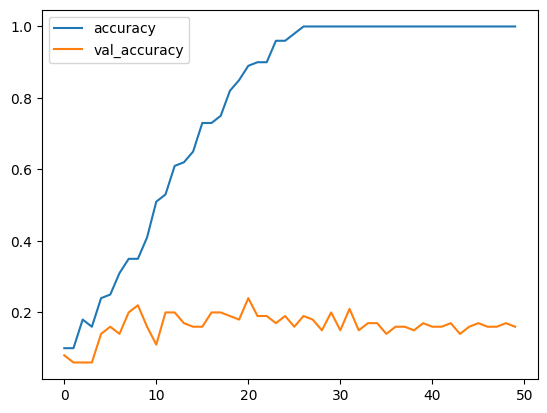

In [26]:
# Plot training and testing curves

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [27]:
# Inspect the checkpoint directory

! ls -lh model_checkpoints_best

total 184K
-rw-r--r-- 1 root root   77 Jun  2 00:47 checkpoint
-rw-r--r-- 1 root root 174K Jun  2 00:47 checkpoint.data-00000-of-00001
-rw-r--r-- 1 root root 1.7K Jun  2 00:47 checkpoint.index


In [28]:
# Create a new model with the saved weights

model2 = get_new_model()
model2.load_weights(checkpoint_best_path)
get_test_accuracy(model2, x_test, y_test)

accuracy: 0.240


Clear directory:

In [29]:
! rm -r model_checkpoints model_checkpoints_best

## 5-2) Saving the weights after training

In [30]:
model = get_new_model()
model.fit(x_train, y_train, epochs=3, batch_size = 32)
model.save_weights('my_model')

Epoch 1/3


4/4 [==============================] - 1s 16ms/step - loss: 2.3044 - accuracy: 0.1200
Epoch 2/3
4/4 [==============================] - 0s 15ms/step - loss: 2.2645 - accuracy: 0.1500
Epoch 3/3
4/4 [==============================] - 0s 20ms/step - loss: 2.2426 - accuracy: 0.1500


In [31]:
get_test_accuracy(model, x_test, y_test)

accuracy: 0.060


In [32]:
#create a new model 

model2 = get_new_model()
model2.load_weights('my_model')
get_test_accuracy(model2, x_test, y_test)

accuracy: 0.060


# 6) Saving the Entire Model

## 6-1) Saving the model during training (using checkpoints)

Create checkpoint that saves whole model, not just weights:

In [33]:
# Create Tensorflow checkpoint object

checkpoint_path = 'model_checkpoints' 
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_frequency='epoch',
                             save_weights_only=False,
                             verbose=1)

In [34]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x_train, y_train, epochs=3, callbacks=[checkpoint])

Epoch 1/3
3/4 [=====================>........] - ETA: 0s - loss: 2.2875 - accuracy: 0.1146
Epoch 1: saving model to model_checkpoints


4/4 [==============================] - 2s 367ms/step - loss: 2.2954 - accuracy: 0.1100
Epoch 2/3
1/4 [======>.......................] - ETA: 0s - loss: 2.2915 - accuracy: 0.0625
Epoch 2: saving model to model_checkpoints


4/4 [==============================] - 1s 227ms/step - loss: 2.2656 - accuracy: 0.1000
Epoch 3/3
4/4 [==============================] - ETA: 0s - loss: 2.2521 - accuracy: 0.1200
Epoch 3: saving model to model_checkpoints


4/4 [==============================] - 1s 237ms/step - loss: 2.2521 - accuracy: 0.1200


Inspect what the checkpoint has created:

In [35]:
# Have a look at what the checkpoint creates

! ls -lh model_checkpoints

total 168K
drwxr-xr-x 2 root root 4.0K Jun  2 00:50 assets
-rw-r--r-- 1 root root   56 Jun  2 00:50 fingerprint.pb
-rw-r--r-- 1 root root  15K Jun  2 00:50 keras_metadata.pb
-rw-r--r-- 1 root root 139K Jun  2 00:50 saved_model.pb
drwxr-xr-x 2 root root 4.0K Jun  2 00:50 variables


In [36]:
# Enter variables directory

! ls -lh model_checkpoints/variables

total 184K
-rw-r--r-- 1 root root 178K Jun  2 00:50 variables.data-00000-of-00001
-rw-r--r-- 1 root root 1.9K Jun  2 00:50 variables.index


In [37]:
# Get the model's test accuracy

get_test_accuracy(model, x_test, y_test)

accuracy: 0.060


Create new model:

In [38]:
# Reload model from scratch

model2 = load_model(checkpoint_path)
get_test_accuracy(model2, x_test, y_test)

accuracy: 0.060


## 6-2) Saving the model after training (using .h5 format)

In [39]:
# Save the model in .h5 format
model = get_new_model()
model.fit(x_train, y_train, epochs=3)
model.save('my_model.h5')

Epoch 1/3
4/4 [==============================] - 1s 27ms/step - loss: 2.3692 - accuracy: 0.0600
Epoch 2/3
4/4 [==============================] - 0s 28ms/step - loss: 2.2941 - accuracy: 0.1200
Epoch 3/3
4/4 [==============================] - 0s 39ms/step - loss: 2.2684 - accuracy: 0.1600


In [40]:
# Inspect .h5 file

! ls -lh my_model.h5

-rw-r--r-- 1 root root 213K Jun  2 00:51 my_model.h5


In [41]:
get_test_accuracy(model, x_test, y_test)

accuracy: 0.120


In [42]:
# create a new model

model3 = load_model('my_model.h5')
get_test_accuracy(model3, x_test, y_test)

accuracy: 0.120


Clear directory:

In [43]:
! rm -r model_checkpoints
! rm my_model.h5

# 7) Loading pre-trained Keras models

In this section, we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications (built-in models). Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

#### Import and build Keras ResNet50 model

In [44]:
# Build Keras ResNet50 model

from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')

# model = load_model('gdrive/My Drive/Colab Notebooks/W8/models/keras_ResNet50.h5')

102967424/102967424 [==============================] - 1s 0us/step


In [45]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

 n)                                                                                               


 conv2_block3_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block3_2_relu[0][0]']    


 conv2_block3_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block3_3_conv[0][0]']    


 ization)                                                                                         


 conv2_block3_add (Add)         (None, 56, 56, 256)  0           ['conv2_block2_out[0][0]',       


                                                                  'conv2_block3_3_bn[0][0]']      


 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       


 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       


 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    


 ization)                                                                                         


 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      


 n)                                                                                               


 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block1_1_relu[0][0]']    


 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    


 ization)                                                                                         


 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      


 n)                                                                                               


 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv2_block3_out[0][0]']       


 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    


 conv3_block1_0_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_0_conv[0][0]']    


 ization)                                                                                         
                                                                                                  
 conv3_block1_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_0_bn[0][0]',      
                                                                  'conv3_block1_3_bn[0][0]']      
                                                                                                  
 conv3_block1_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block1_add[0][0]']       
                                                                                                  
 conv3_blo

#### Import and preprocess 3 sample images

In [47]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('/content/gdrive/MyDrive/9 - Transfer Learning/lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('/content/gdrive/MyDrive/9 - Transfer Learning/viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('/content/gdrive/MyDrive/9 - Transfer Learning/water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [48]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

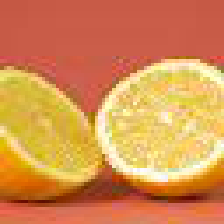

In [49]:
# Display image

lemon_img

In [50]:
# Display top 5 predictions

get_top_5_predictions(lemon_img)

35363/35363 [==============================] - 0s 0us/step


,prediction,probability
1,consomme,0.227801
2,lemon,0.221758
3,eggnog,0.151335
4,ladle,0.040088
5,spotlight,0.029197


##### Image 2: viaduct

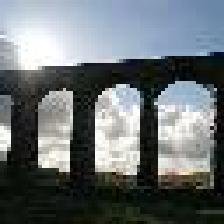

In [51]:
# Display image

viaduct_img

In [52]:
# Display top 5 predictions

get_top_5_predictions(viaduct_img)

1/1 [==============================] - 0s 131ms/step


,prediction,probability
1,vault,0.367951
2,prison,0.111742
3,viaduct,0.110737
4,window_screen,0.088231
5,fire_screen,0.020675


##### Image 3: water tower

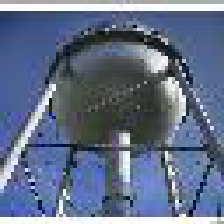

In [53]:
# Display image

water_tower_img

In [54]:
# Display top 5 predictions

get_top_5_predictions(water_tower_img)

1/1 [==============================] - 0s 128ms/step


,prediction,probability
1,solar_dish,0.384683
2,ladle,0.196177
3,planetarium,0.116683
4,strainer,0.04999
5,jigsaw_puzzle,0.021947


# 8) Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

In this section, we'll be using [Tensorflow Hub](https://www.tensorflow.org/hub). Specifically, we we'll be using Google's MobileNet v1 model. Please see the description on this [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

In [55]:
import tensorflow_hub as hub
from tensorflow.keras.models import load_model

In [56]:
# Build Google's Mobilenet v1 model

module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])

# module = load_model('gdrive/My Drive/Colab Notebooks/W8/models/Tensorflow_mobileNet_v1')
# model = Sequential([hub.KerasLayer(module)])
# model.build(input_shape=[None, 160, 160, 3])

In [57]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              1343049   
                                                                 
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


#### Use MobileNet model to classify images

In [59]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('/content/gdrive/MyDrive/9 - Transfer Learning/lemon.jpg', target_size=(160, 160))
viaduct_img = load_img('/content/gdrive/MyDrive/9 - Transfer Learning/viaduct.jpg', target_size=(160, 160))
water_tower_img = load_img('/content/gdrive/MyDrive/9 - Transfer Learning/water_tower.jpg', target_size=(160, 160))

In [62]:
# Read in categories text file

with open('/content/gdrive/MyDrive/9 - Transfer Learning/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [63]:
# Useful function: presents top 5 predictions

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'],
                             index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
            
    return top_preds

##### Image 1: lemon

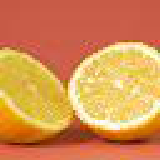

In [64]:
lemon_img

In [65]:
get_top_5_predictions(lemon_img)

1/1 [==============================] - 0s 205ms/step


,prediction
1,shower cap
2,tray
3,candle
4,brassiere
5,African chameleon


##### Image 2: viaduct

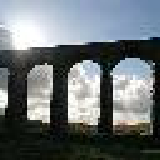

In [66]:
viaduct_img

In [67]:
get_top_5_predictions(viaduct_img)

1/1 [==============================] - 0s 24ms/step


,prediction
1,viaduct
2,pier
3,dam
4,prison
5,solar dish


##### Image 3: water tower

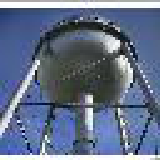

In [68]:
water_tower_img

In [69]:
get_top_5_predictions(water_tower_img)

1/1 [==============================] - 0s 20ms/step


,prediction
1,solar dish
2,water tower
3,aircraft carrier
4,jigsaw puzzle
5,oxygen mask
